In [ ]:
# upload necessary files

from google.colab import files
files.upload()

Saving traces.csv to traces.csv


{'traces.csv': b'fe5bbf71bf12c382d95aa422ed4be759,0.0791015625,-0.31640625,-0.1513671875,-0.1376953125,0.0166015625,-0.4365234375,-0.248046875,-0.2177734375,-0.05078125,-0.1689453125,-0.01953125,-0.04296875,0.080078125,-0.1181640625,0.021484375,-0.01171875,0.111328125,-0.40625,-0.234375,-0.2080078125,-0.044921875,-0.24609375,-0.1015625,-0.1142578125,0.0263671875,-0.1513671875,-0.01953125,-0.05078125,0.07421875,-0.255859375,-0.1083984375,-0.111328125,0.03125,-0.107421875,0.03125,-0.0078125,0.107421875,-0.0458984375,0.080078125,0.033203125,0.1435546875,-0.08203125,0.0419921875,0.001953125,0.1103515625,-0.103515625,0.0283203125,-0.0087890625,0.109375,-0.154296875,-0.015625,-0.044921875,0.083984375,-0.2109375,-0.064453125,-0.0771484375,0.0595703125,-0.18359375,-0.04296875,-0.060546875,0.072265625,-0.251953125,-0.0966796875,-0.103515625,0.0390625,-0.111328125,0.021484375,-0.013671875,0.1064453125,-0.1064453125,0.0302734375,0.0,0.12109375,-0.41796875,-0.25,-0.22265625,-0.0576171875,-0.266601

In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [ ]:
# utility functions to read traces into arrays

def parse_plaintext(pt_str):
    """
    Convert a hexadecimal plaintext string into a list of 16 bytes.
    """
    pt_str = pt_str.replace(" ", "").strip()
    return [int(pt_str[i:i+2], 16) for i in range(0, len(pt_str), 2)]

def load_data(csv_file):
    """
    Load the CSV file.
    Assumes:
      - First column: plaintext (hex string).
      - Remaining columns: power trace values.
    Returns a list of plaintexts (each a list of 16 integers) and a 2D NumPy array of traces.
    """
    df = pd.read_csv(csv_file, header=None)
    plaintexts = df.iloc[:, 0].tolist()
    traces = df.iloc[:, 1:].values.astype(np.float64)
    plaintexts = [parse_plaintext(pt) for pt in plaintexts]
    return plaintexts, traces

csv_file = "traces.csv"
plaintexts, traces = load_data(csv_file)
print(f"Loaded {len(plaintexts)} traces with {traces.shape[1]} time samples each.")

Loaded 50 traces with 5000 time samples each.


In [ ]:
# compute mean & standard deviation over time (per sample)

mean_trace = np.mean(traces, axis=0)
std_trace = np.std(traces, axis=0, ddof=1)

# compute covariance matrix (each time sample with every other sample)

cov_matrix = np.cov(traces, rowvar=False)  # shape: (n_time_samples, n_time_samples)

# for demonstration...compute correlation coefficient between first trace & average trace
r = np.corrcoef(traces[0, :], mean_trace)[0, 1]

print("Mean of traces (first 10 samples):", mean_trace[:10])
print("Std of traces (first 10 samples):", std_trace[:10])
print("Covariance matrix shape:", cov_matrix.shape)
print("Correlation coefficient (first trace vs average trace):", r)

Mean of traces (first 10 samples): [ 0.07884766 -0.31253906 -0.14927734 -0.13822266  0.01318359 -0.43814453
 -0.25263672 -0.22294922 -0.05230469 -0.17494141]
Std of traces (first 10 samples): [0.00511376 0.007108   0.00604256 0.00517204 0.00543637 0.0070686
 0.00708411 0.00631114 0.00568115 0.00746864]
Covariance matrix shape: (5000, 5000)
Correlation coefficient (first trace vs average trace): 0.9975256397405348


In [ ]:
# utility functions to find most probable key guess using power traces (for each sub-byte of AES)
# function definitions for hamming weight, computing correlation & recovering one key byte

# define AES S-box (256 entries)
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def hw(x):
    """Compute Hamming Weight (number of 1's) for an 8-bit number."""
    return bin(x).count("1")

def compute_max_corr(p, m):
    """
    Compute the maximum absolute Pearson correlation coefficient between a predicted vector p
    and each column of measured data m.
    """
    n = len(p)
    p_mean = np.mean(p)
    p_std = np.std(p, ddof=1)
    m_mean = np.mean(m, axis=0)
    m_std = np.std(m, axis=0, ddof=1)
    m_std[m_std == 0] = 1e-10  # avoid division by zero
    r = np.sum((p - p_mean).reshape(-1, 1) * (m - m_mean), axis=0) / ((n - 1) * p_std * m_std)
    return np.max(np.abs(r))

def recover_key_byte(plaintexts, traces, byte_index):
    """
    For the given byte position, try all 256 key candidates.
    For each candidate, compute:
      HW( sbox( plaintext_byte XOR candidate ) )
    and then the maximum correlation with the traces.
    Returns the candidate with the highest correlation.
    """
    best_candidate = None
    best_corr = -1
    for candidate in range(256):
        pred = np.array([hw(sbox[pt[byte_index] ^ candidate]) for pt in plaintexts])
        corr_val = compute_max_corr(pred, traces)
        if corr_val > best_corr:
            best_corr = corr_val
            best_candidate = candidate
    return best_candidate

# example: find most probable key guess for sub-byte 0
key_guess_byte0 = recover_key_byte(plaintexts, traces, 0)
print(f"Most probable key guess for sub-byte 0: {key_guess_byte0:02x}")

Most probable key guess for sub-byte 0: 2b


In [ ]:
# retrieve all 16 subbytes of AES using CPA

def cpa_attack(plaintexts, traces):
    recovered_key = []
    for byte_index in range(16):
        key_byte = recover_key_byte(plaintexts, traces, byte_index)
        recovered_key.append(key_byte)
        print(f"Recovered key byte {byte_index}: {key_byte:02x}")
    return recovered_key

recovered_key = cpa_attack(plaintexts, traces)
print("Recovered key:", " ".join(f"{kb:02x}" for kb in recovered_key))

Recovered key byte 0: 2b
Recovered key byte 1: 7e
Recovered key byte 2: 15
Recovered key byte 3: 16
Recovered key byte 4: 28
Recovered key byte 5: ae
Recovered key byte 6: d2
Recovered key byte 7: a6
Recovered key byte 8: ab
Recovered key byte 9: f7
Recovered key byte 10: 15
Recovered key byte 11: 88
Recovered key byte 12: 09
Recovered key byte 13: cf
Recovered key byte 14: 4f
Recovered key byte 15: 3c
Recovered key: 2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c


In [ ]:
# software timer to measure time taken for CPA to complete 16-byte retrieval

start_time = time.time()
recovered_key = cpa_attack(plaintexts, traces)
elapsed_time = time.time() - start_time
print(f"Total CPA time: {elapsed_time:.3f} seconds")

Recovered key byte 0: 2b
Recovered key byte 1: 7e
Recovered key byte 2: 15
Recovered key byte 3: 16
Recovered key byte 4: 28
Recovered key byte 5: ae
Recovered key byte 6: d2
Recovered key byte 7: a6
Recovered key byte 8: ab
Recovered key byte 9: f7
Recovered key byte 10: 15
Recovered key byte 11: 88
Recovered key byte 12: 09
Recovered key byte 13: cf
Recovered key byte 14: 4f
Recovered key byte 15: 3c
Total CPA time: 8.558 seconds


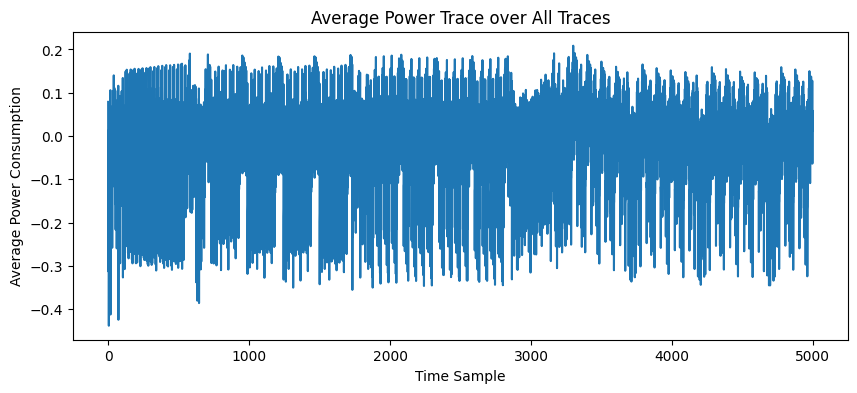

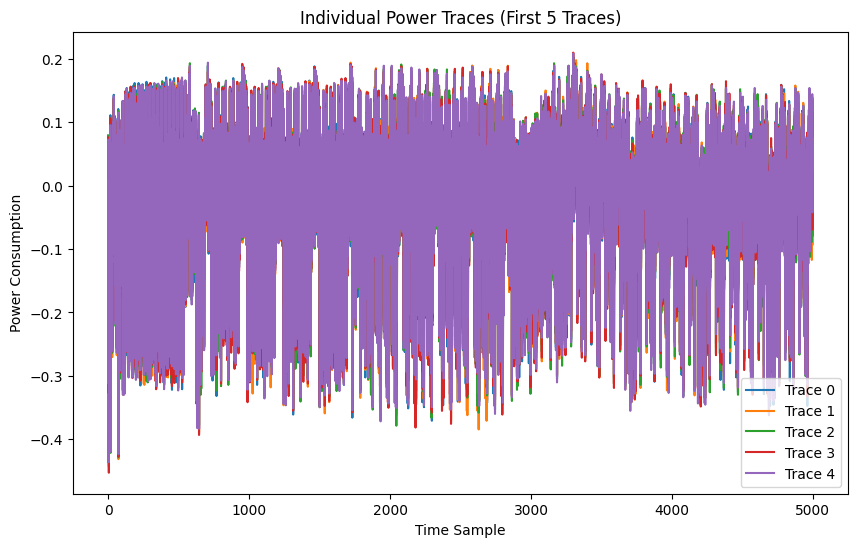

In [ ]:
# plot average power trace over time

avg_trace = np.mean(traces, axis=0)
plt.figure(figsize=(10, 4))
plt.plot(avg_trace)
plt.xlabel("Time Sample")
plt.ylabel("Average Power Consumption")
plt.title("Average Power Trace over All Traces")
plt.show()

# plot few individual traces to observe differences

plt.figure(figsize=(10, 6))
for i in range(min(5, len(traces))):
    plt.plot(traces[i], label=f"Trace {i}")
plt.xlabel("Time Sample")
plt.ylabel("Power Consumption")
plt.title("Individual Power Traces (First 5 Traces)")
plt.legend()
plt.show()


Recovered key byte 0: 80
Recovered key byte 1: e7
Recovered key byte 2: a9
Recovered key byte 3: 33
Recovered key byte 4: f9
Recovered key byte 5: ae
Recovered key byte 6: 90
Recovered key byte 7: 23
Recovered key byte 8: c3
Recovered key byte 9: a9
Recovered key byte 10: d7
Recovered key byte 11: 8d
Recovered key byte 12: 0f
Recovered key byte 13: 2b
Recovered key byte 14: ad
Recovered key byte 15: 3b
Recovered key byte 0: fe
Recovered key byte 1: d5
Recovered key byte 2: 9d
Recovered key byte 3: 7a
Recovered key byte 4: 97
Recovered key byte 5: 95
Recovered key byte 6: 41
Recovered key byte 7: 1f
Recovered key byte 8: 2c
Recovered key byte 9: 9f
Recovered key byte 10: 91
Recovered key byte 11: 30
Recovered key byte 12: d5
Recovered key byte 13: 7a
Recovered key byte 14: fa
Recovered key byte 15: 64
Recovered key byte 0: 99
Recovered key byte 1: 8e
Recovered key byte 2: 89
Recovered key byte 3: e1
Recovered key byte 4: 67
Recovered key byte 5: ae
Recovered key byte 6: f0
Recovered key

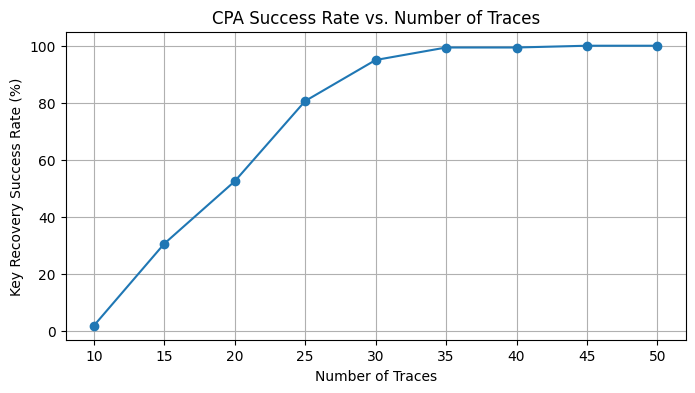

In [ ]:
# perform CPA with different numbers of traces & plot success rate(s)

def evaluate_success_rate(plaintexts, traces, expected_key, iterations=10):
    num_traces_list = list(range(10, len(plaintexts) + 1, 5))
    success_rates = []
    for num in num_traces_list:
        correct_counts = []
        for _ in range(iterations):
            # randomly select subset of traces
            indices = np.random.choice(len(plaintexts), num, replace=False)
            subset_plaintexts = [plaintexts[i] for i in indices]
            subset_traces = traces[indices, :]
            recovered = cpa_attack(subset_plaintexts, subset_traces)
            correct = sum(1 for r, e in zip(recovered, expected_key) if r == e)
            correct_counts.append(correct / 16)  # fraction of correct key bytes
        avg_success = np.mean(correct_counts)
        success_rates.append(avg_success)
        print(f"Using {num} traces, average success rate: {avg_success*100:.1f}%")
    return num_traces_list, success_rates

# expected key (from above)
expected_key = [0x2b, 0x7e, 0x15, 0x16,
                0x28, 0xae, 0xd2, 0xa6,
                0xab, 0xf7, 0x15, 0x88,
                0x09, 0xcf, 0x4f, 0x3c]

num_traces_list, success_rates = evaluate_success_rate(plaintexts, traces, expected_key, iterations=10)

plt.figure(figsize=(8, 4))
plt.plot(num_traces_list, [sr*100 for sr in success_rates], marker='o')
plt.xlabel("Number of Traces")
plt.ylabel("Key Recovery Success Rate (%)")
plt.title("CPA Success Rate vs. Number of Traces")
plt.grid(True)
plt.show()